# Part 1: Fully Connected Layers

Daniel-Alexandru Bejan (474404)
Patrick Schaper (534366)

The provided dataset contains possible combinations for the game Yathzee. If you don’t know the rules for this dice game, please have a look at: https://en.wikipedia.org/wiki/Yahtzee.

Please note: the dataset is imbalanced. This means that you might need to balance it first
before you will get good results! There a several possible solutions, please read: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758 for a better understanding.

You will need to build a neural network that is able to predict the label for 5 thrown dice. The available labels are mentioned in the table below.

- 3-of-a-kind: Three dice the same.
- 4-of-a-kind: Four dice the same.
- Full-house: Three of one number and two of another
- small-straight Four sequential dice: (1-2-3-4, 2-3-4-5, or 3-4-5-6)
- Large-straight Five sequential dice: (1-2-3-4-5 or 2-3-4-5-6)
- Yathzee: All five dice the same
- Nothing: None of the above combinations has been thrown

**Goal of the assignment**

The overall goal is to experiment with deep learning and find out what gives you the
best results. Don’t forget to compare the results and write a conclusion!
Experiments we expect you to carry out:
- Playing around with different networks sizes
 - Different number of layers
 - Different number of neurons per layer
 - At least 6 different networks with a minimum of 1 hidden layer per network
- Comparison of different activation functions:
 - Sigmoid
 - Tanh
 - ReLu
- Difference with and without dropout.

The notebook should contain:
- For each neural network that you train: graphs from TensorBoard or Matplotlib showing the accuracy and the loss for train set and validation set and the accuracy scores for the test set.
- Your observations and conclusions per network (and graph)!
- An export of your best trained network and a way to run this exported model.

**Hints**

In order to build proper neural networks, keep in mind:
- Convert the labels into one-hot-encoded values.
- Use cross-entropy as loss function for classification.
- Create a proper output layer that uses SoftMax activation.
- Use the accuracy metric to measure your classification performance.
- Avoid overfitting by using dropout, a test set (which you use in the end) and cross validation.

Export your best model and add a cell to your notebook that loads the model and is
able to validate your model, by loading in a dataset from file and feeding it into the
network. This cell should show the accuracy of the classifier.


## Load the Data

In [1]:
import pandas as pd
import numpy as np

raw_df = pd.read_csv('MLBD-dataset-yahtzee.csv')
raw_df.head() 

,dice1,dice2,dice3,dice4,dice5,label
0,3,6,6,2,5,nothing
1,3,6,1,3,4,nothing
2,2,2,5,5,3,nothing
3,1,3,6,6,1,nothing
4,1,4,6,3,5,small-straight


## Analyse the Data

In [2]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5832 entries, 0 to 5831
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dice1   5832 non-null   int64 
 1   dice2   5832 non-null   int64 
 2   dice3   5832 non-null   int64 
 3   dice4   5832 non-null   int64 
 4   dice5   5832 non-null   int64 
 5   label   5832 non-null   object
dtypes: int64(5), object(1)
memory usage: 273.5+ KB


We see that there are no null values and all data sets are therefore complete

### How balanced is our data set?

In [3]:
count_values = raw_df.groupby(['label'])['label'].count()
count_values

label
four-of-a-kind      116
full-house          221
large-straight      178
nothing            3868
small-straight      549
three-of-a-kind     896
yathzee               4
Name: label, dtype: int64

### Result of analysing

We see a very unbalanced data set. One rubric stands out particularly strongly. The number of "yathzee's" is just 4. According to the rules of the game, a "yathzee" occurs when all dice show the same number. So we add the missing records.

In [4]:
raw_df[raw_df['label'] == 'yathzee']

,dice1,dice2,dice3,dice4,dice5,label
1101,5,5,5,5,5,yathzee
1180,2,2,2,2,2,yathzee
1602,6,6,6,6,6,yathzee
5504,3,3,3,3,3,yathzee


In [5]:
df = raw_df.copy()

df.loc[len(df.index)] = [1,1,1,1,1,'yathzee']
df.loc[len(df.index)] = [4,4,4,4,4,'yathzee']

## Extract the data

How to split the dataset into Features=X and Target=Y. We also convert the strings in our target column to numbers, since a model works better with numbers.

Class=0, n=3868 (66.301%)
Class=1, n=549 (9.410%)
Class=2, n=896 (15.358%)
Class=3, n=178 (3.051%)
Class=4, n=221 (3.788%)
Class=5, n=116 (1.988%)
Class=6, n=6 (0.103%)


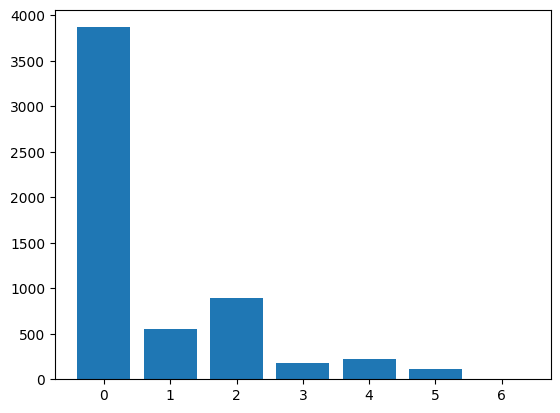

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df_for_this_cell = df #bal_df

y_labels = df_for_this_cell.label.unique()
df.label = pd.factorize(df.label)[0]

features = []
for feature in df_for_this_cell.columns:
    if feature != 'label':
        features.append(feature)
        
X = df_for_this_cell[features]
y = df_for_this_cell['label']

y_encoded = LabelEncoder().fit_transform(y)

counter = Counter(y_encoded)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
plt.bar(counter.keys(), counter.values())
plt.show()

## Cross validation - split the dataset

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [8]:
import tensorflow as tf

from tensorflow import keras

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test =  tf.keras.utils.normalize(X_test, axis=1)

2023-01-28 00:54:51.761595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([3091,  426,  734,  147,  175,   89,    5]))

In [10]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([777, 123, 162,  31,  46,  27,   1]))

## Balancing the data

In order to train our model better, we balance our data set. To avoid overfitting we do this after splitting the data into training and test data. Although the values are then somewhat worse (we have done several tests), our model is more robust this way.

We first determine the median of the number of different classes. Then we apply undersampling to all classes that are above the median. For all data below the median we use oversampling.

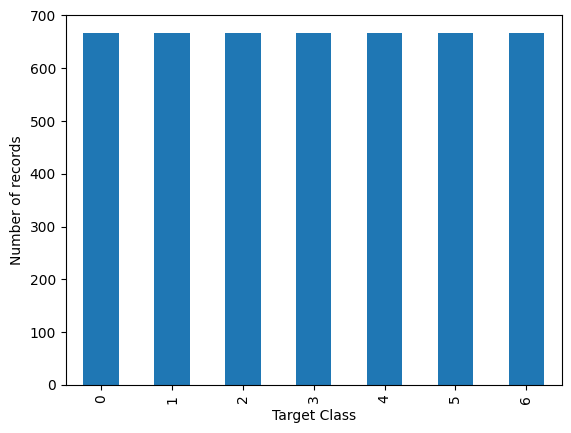

In [11]:
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE

n_samples = int(round(np.unique(y_train, return_counts=True)[1].mean()))

def sampling_strategy(X, y, n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    #target_classes_all = y.value_counts().index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X_train, y_train, n_samples, t='majority'), random_state=1337)
X_under, y_under = under_sampler.fit_resample(X_train, y_train)

over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_under, y_under, n_samples, t='minority'), k_neighbors=2, random_state=1337)

X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

count = y_bal.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

## Load the important libarys

In [12]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Nadam
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Normalization
from tensorflow.keras.callbacks import History, TensorBoard
from sklearn.utils import class_weight

### Normalize X values for keras

In [13]:
normalizer = keras.layers.Normalization()
normalizer.adapt(X_bal)

2023-01-28 00:54:56.573021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define methods for evaluate, create and fill a model

In [14]:
def evaluat_my_model(model, input_data, output_data):
    
    output_data = output_data.values.reshape(-1,1)
    output_data = tf.keras.utils.to_categorical(output_data, np.unique(output_data).size)
    
    evaluation_results = model.evaluate(input_data, output_data)

    return evaluation_results

In [15]:
# variable to save all the params for each model in this notebook
models = []

# Valid command to create a model with 2 hidden layers and 1 dropout layer:
# model = create_mode(X, y, [(300,"relu"),(210,"relu",0.2)] )
# 
# After every hidden layer will be add a normalize layer
#
# The loss function is the categorical_crossentropy from keras for multi category
#
def create_model(input_data, output_data, layers=[], optimizer="adam", endActi="softmax"):
    
    learningRate = 0.0025
    
    inputNeurons = input_data.shape[1]
    outputNeurons = np.unique(output_data).size
    
    model = Sequential()
    
    firstLayer = True
    
    for layer in layers:
        if(firstLayer):
            model.add(Dense(layer[0], input_shape=(inputNeurons,), activation=layer[1]))
            firstLayer = False
        else:
            model.add(Dense(layer[0], activation=layer[1]))
            
        model.add(BatchNormalization())
        
        if(2 < len(layer)):
            model.add(Dropout(layer[2]))
    
    model.add(Dense(outputNeurons, activation=endActi))
    
    if optimizer == "adam":
        opti = Adam(learning_rate=learningRate)
    elif optimizer == "nadam":
        opti = Nadam(learning_rate=learningRate)
    elif optimizer == "sgd":
        opti = SGD(learning_rate=learningRate)
    elif optimizer == "adagrad":
        opti = Adagrad(learning_rate=learningRate)
    else:
        opti = optimizer
    
    model.compile(loss="categorical_crossentropy", optimizer=opti, metrics=["accuracy"], sample_weight_mode="temporary",)
    
    return model

def create_fit_model(input_data, output_data, layers=[], optimizer="adam", endActi="softmax", batchSize=128, epochs=250, verbose=0, withHistory=0):
        
        model = create_model(input_data, output_data, layers, optimizer=optimizer, endActi=endActi)
    
        #class_weights = class_weight.compute_class_weight( class_weight = "balanced", classes = np.unique(y_bal), y = y_bal)
    
        inputNeurons = input_data.shape[1]
        outputNeurons = np.unique(output_data).size

        # The output classes will transform to categorical
        output_data = output_data.values.reshape(-1,1)
        output_data = tf.keras.utils.to_categorical(output_data, outputNeurons)
        y_test_cat = tf.keras.utils.to_categorical(y_test, outputNeurons)
        
        history = History()
        history = model.fit(x=input_data, y=output_data, batch_size=batchSize, epochs=epochs, verbose=verbose, shuffle=True, validation_split=0.2, callbacks=[history])
        evaluate = evaluat_my_model(model=model, input_data=X_test, output_data=y_test)
        models.append({
            'layers':layers,
            'optimizer':optimizer,
            'batchSize':batchSize,
            'epochs':epochs,
            'endActi':endActi,
            'best_lost':evaluate[0],
            'best_accuracy':evaluate[1],
            'loss':history.history['loss'],
            'accuracy':history.history['accuracy'],
            'val_accuracy':history.history['val_accuracy']
            })
        
        if withHistory == 1:
            return model, history
        return model

def plot_acc_loss(history):
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

## Create different Models

At this point it should be mentioned that we have performed this step very often and thus always adjusted the values slightly. In order to fulfill the individual tasks, the various parameters are set.

The models create all with adam optimizer and softmax as proper output function, BatchSize is 32 and epochs 700

example:

(300,"relu") - one hidden layer with 300 output neurons with relu activation
(210, 'sigmoid', 0.2) - one hidden layer with 210 output neurons with sigmoid activation and after 0.2 Dropout

- (300,"relu")
- (300,"relu"), (210,"relu",0.2)
- (300,"relu",0.2), (210,"relu",0.2), (130,"relu",0.2)
- (20,"relu",0.2), (400,"relu",0.3), (130,"relu",0.1)
- (300,"relu"), (210,"sigmoid",0.2), (130,"relu"), (80,"relu")
- (300,"relu"), (210,"tanh",0.2), (130,"relu",0.2), (80,"relu",0.2)
- (300,"relu"), (210,"sigmoid"), (130,"relu"), (80,"relu")
- (300,"relu"), (210,"sigmoid",0.25), (130,"relu",0.2), (80,"relu")
- (300,"relu"), (210,"sigmoid")
- (50,"relu"), (25,"relu",0.2), (10,"sigmoid",0.3), (5,"relu",0.2)
- (300,"tanh"), (170,"tanh"), (100,"tanh")
- (300,"tanh"), (170,"tanh", 0.15), (100,"tanh")

37/37 [==============================] - 0s 500us/step - loss: 1.5171 - accuracy: 0.2931


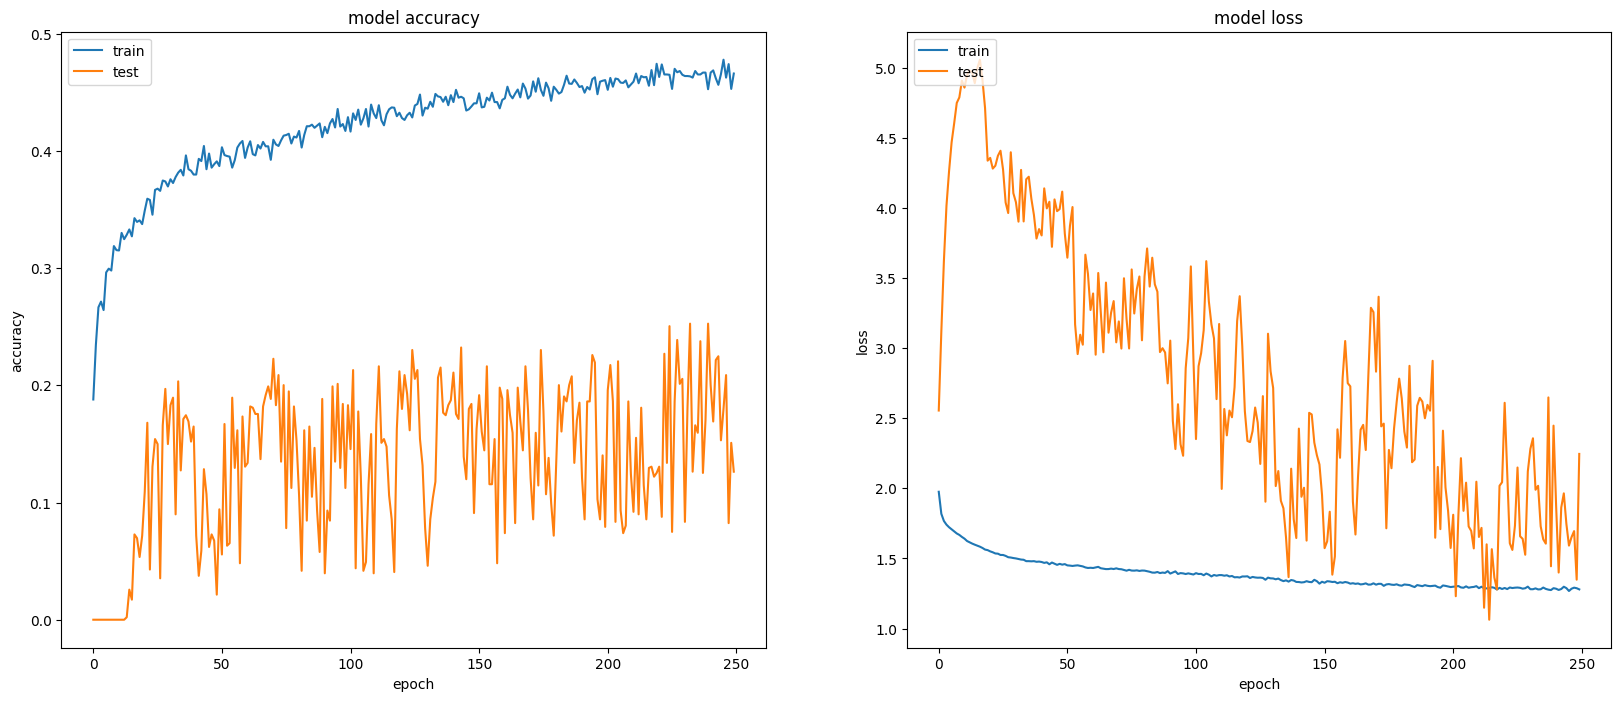

In [16]:
layers = [(50,"relu")]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 513us/step - loss: 1.6065 - accuracy: 0.3162


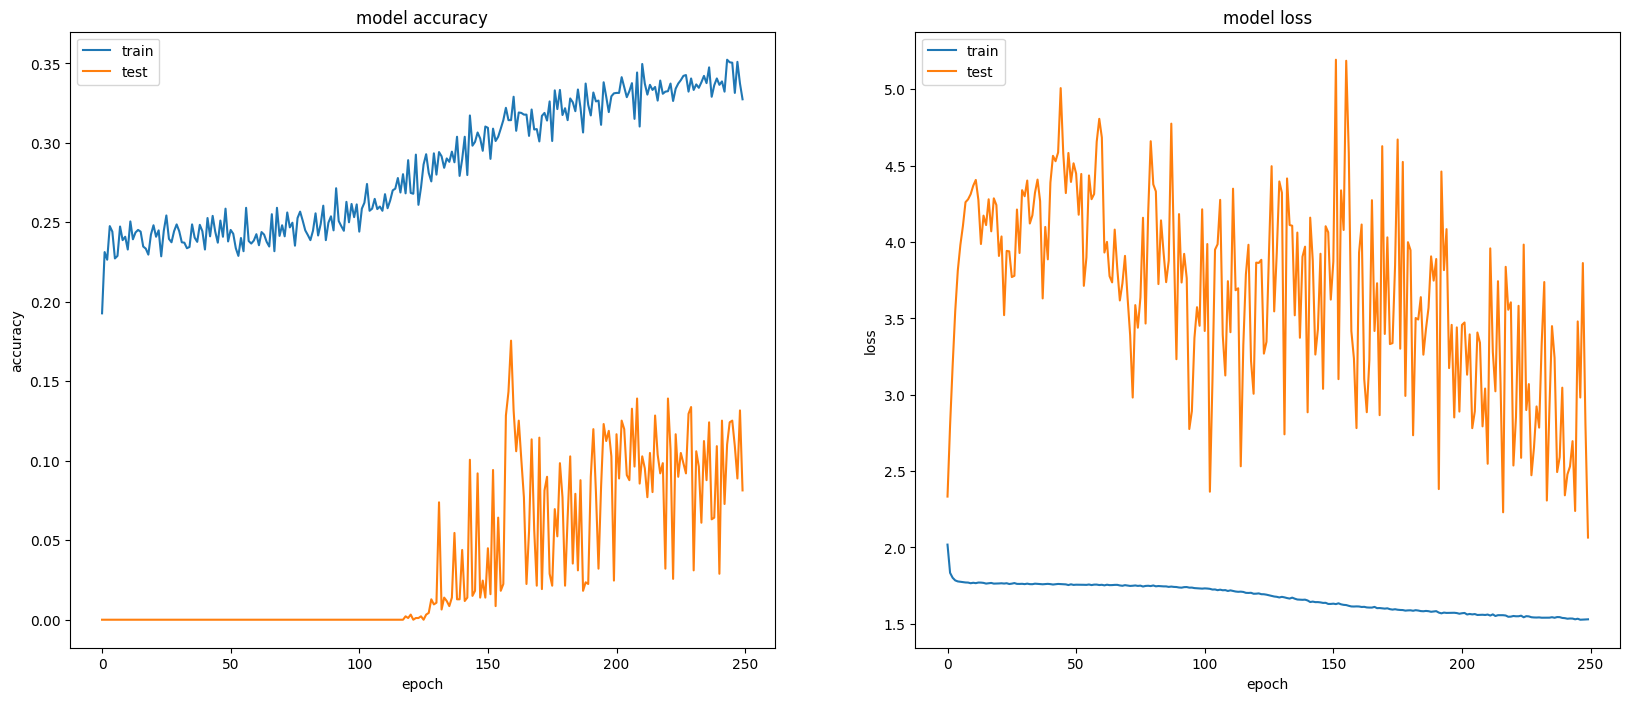

In [17]:
layers = [(50,"tanh")]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 504us/step - loss: 1.6241 - accuracy: 0.3907


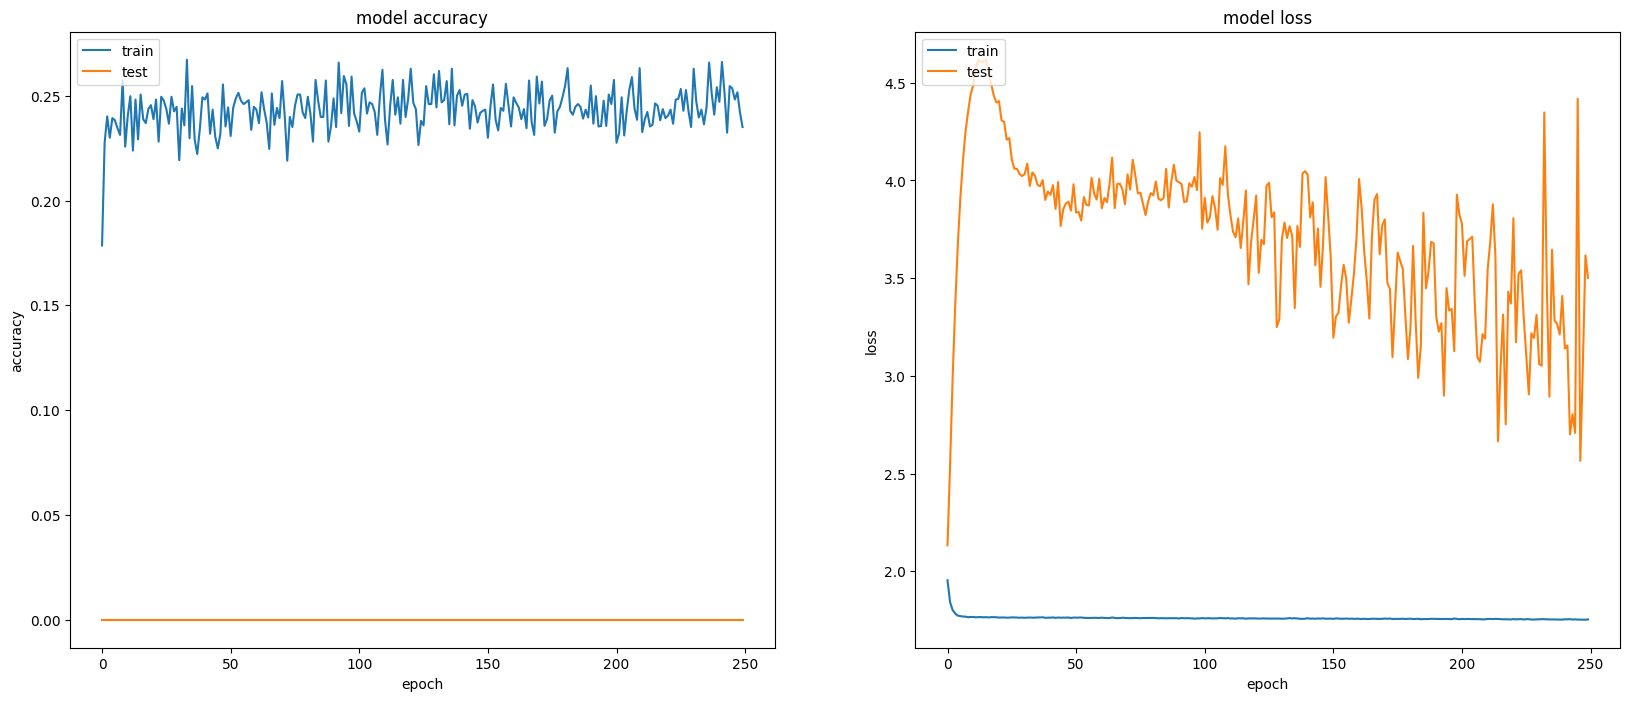

In [18]:
layers = [(50,"sigmoid")]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 543us/step - loss: 0.9630 - accuracy: 0.6067


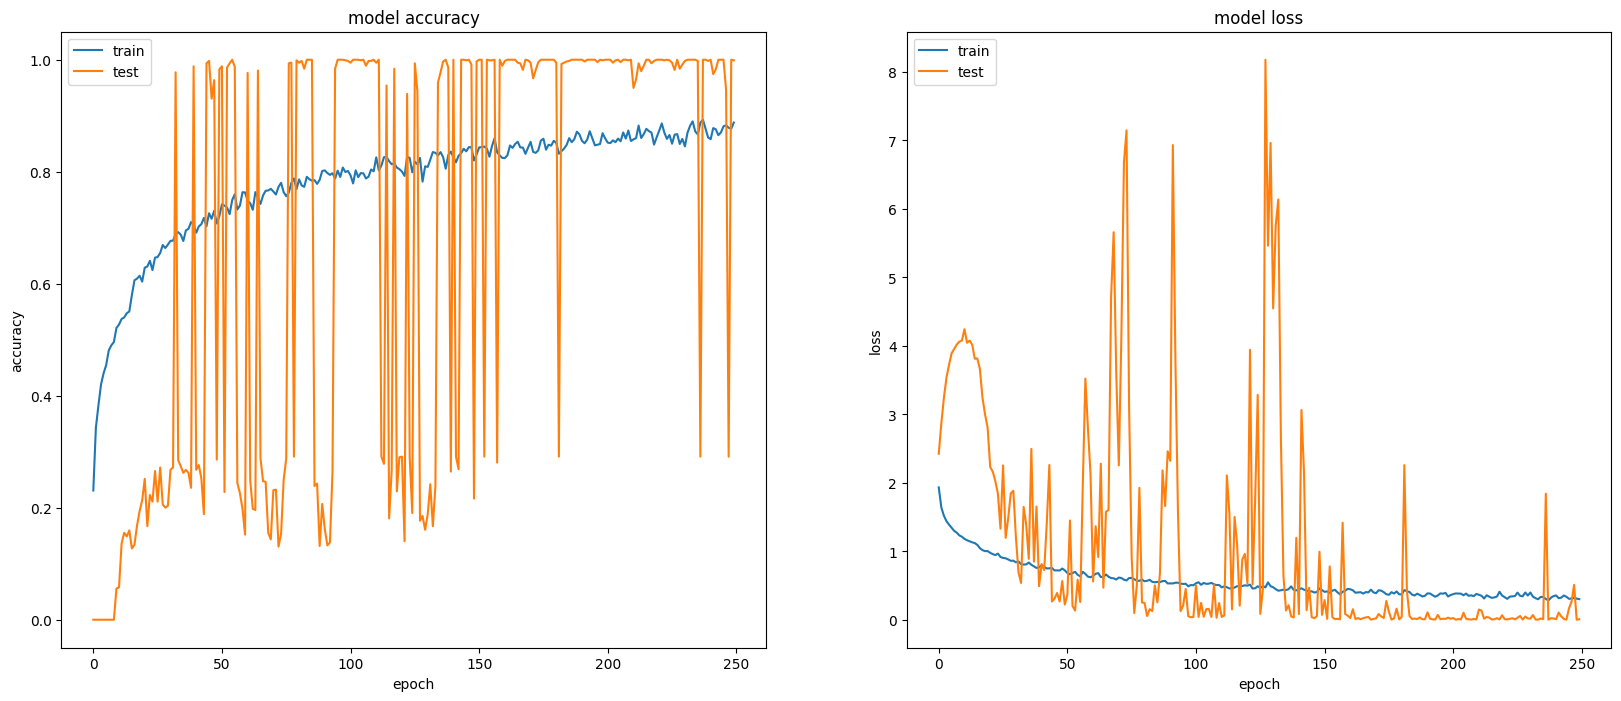

In [19]:
layers = [(50,"relu"),(100,"relu")]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 550us/step - loss: 0.9191 - accuracy: 0.6615


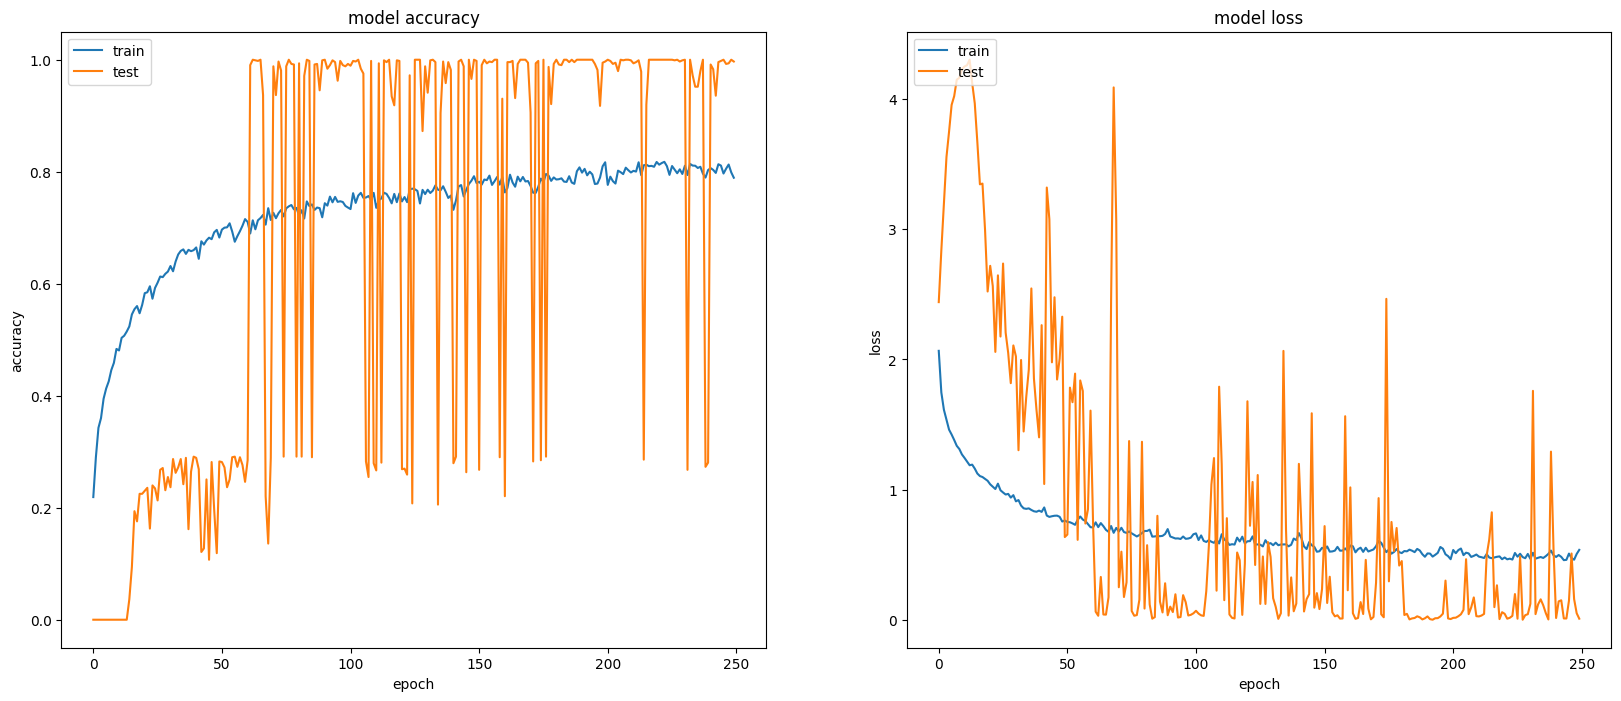

In [20]:
layers = [(50,"relu"),(100,"relu",0.2)]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 626us/step - loss: 0.8106 - accuracy: 0.6461


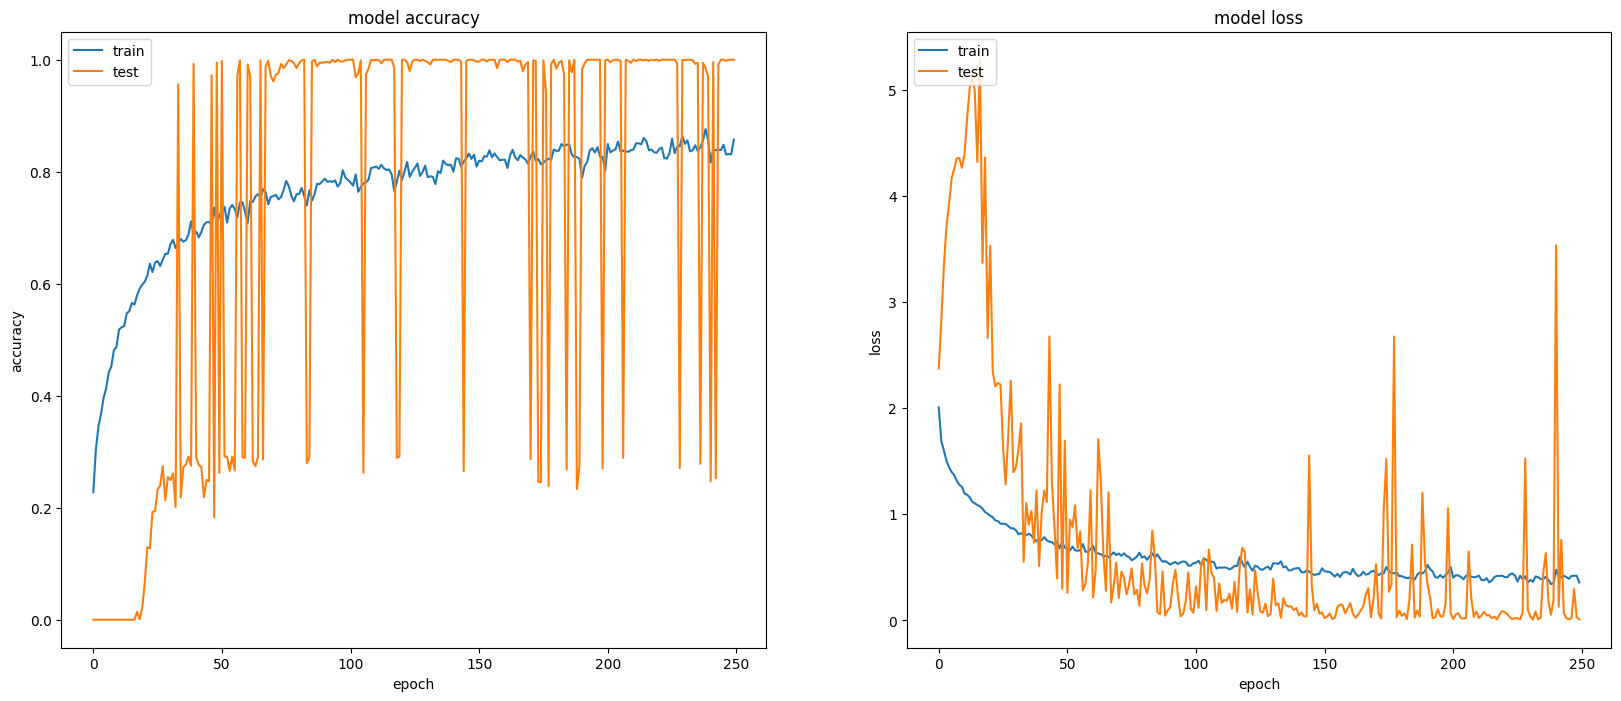

In [21]:
layers = [(50,"relu"),(100,"relu",0.2),(50,"relu")]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 603us/step - loss: 0.6950 - accuracy: 0.6769


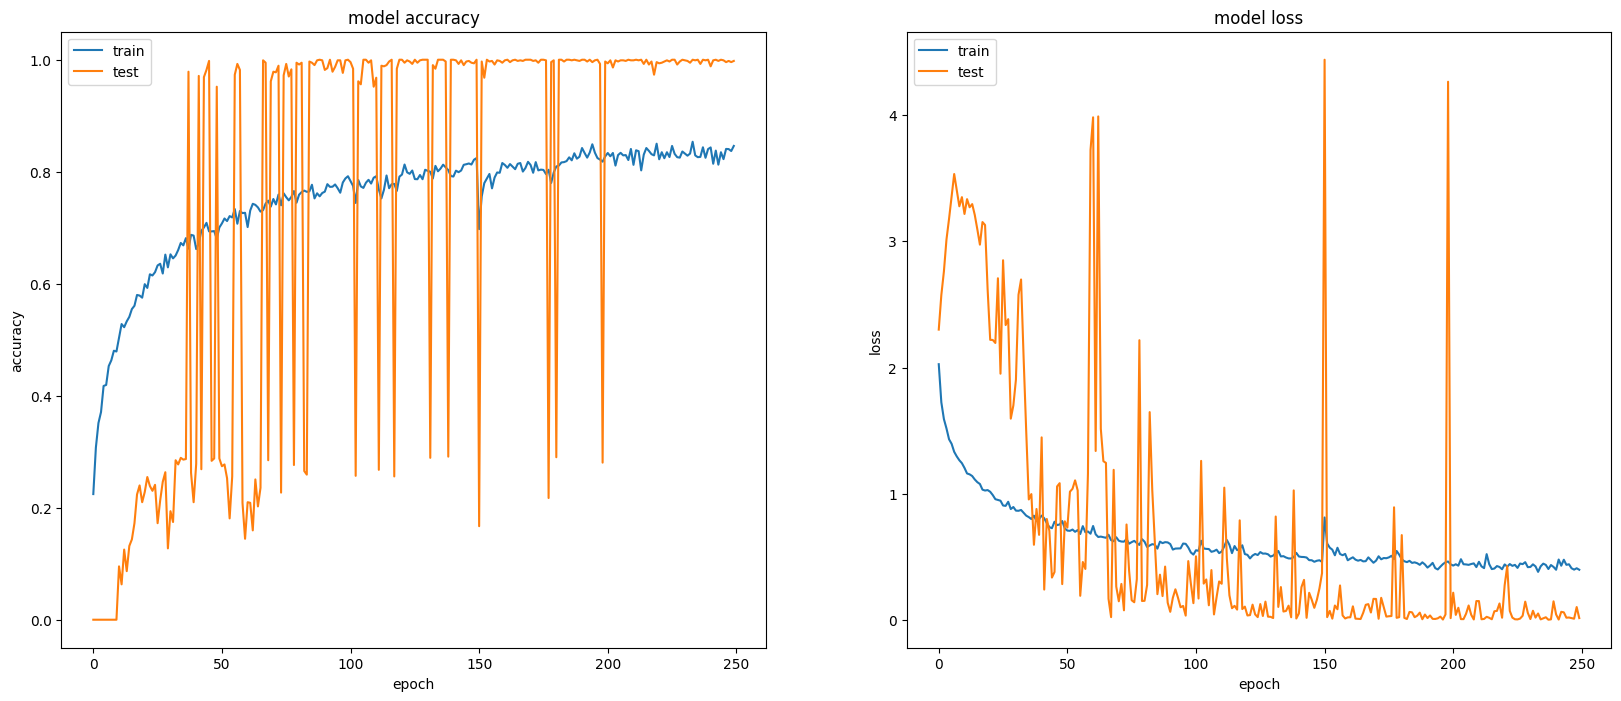

In [22]:
layers = [(50,"relu"),(100,"relu",0.2),(50,"relu",0.1)]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 589us/step - loss: 0.7420 - accuracy: 0.6992


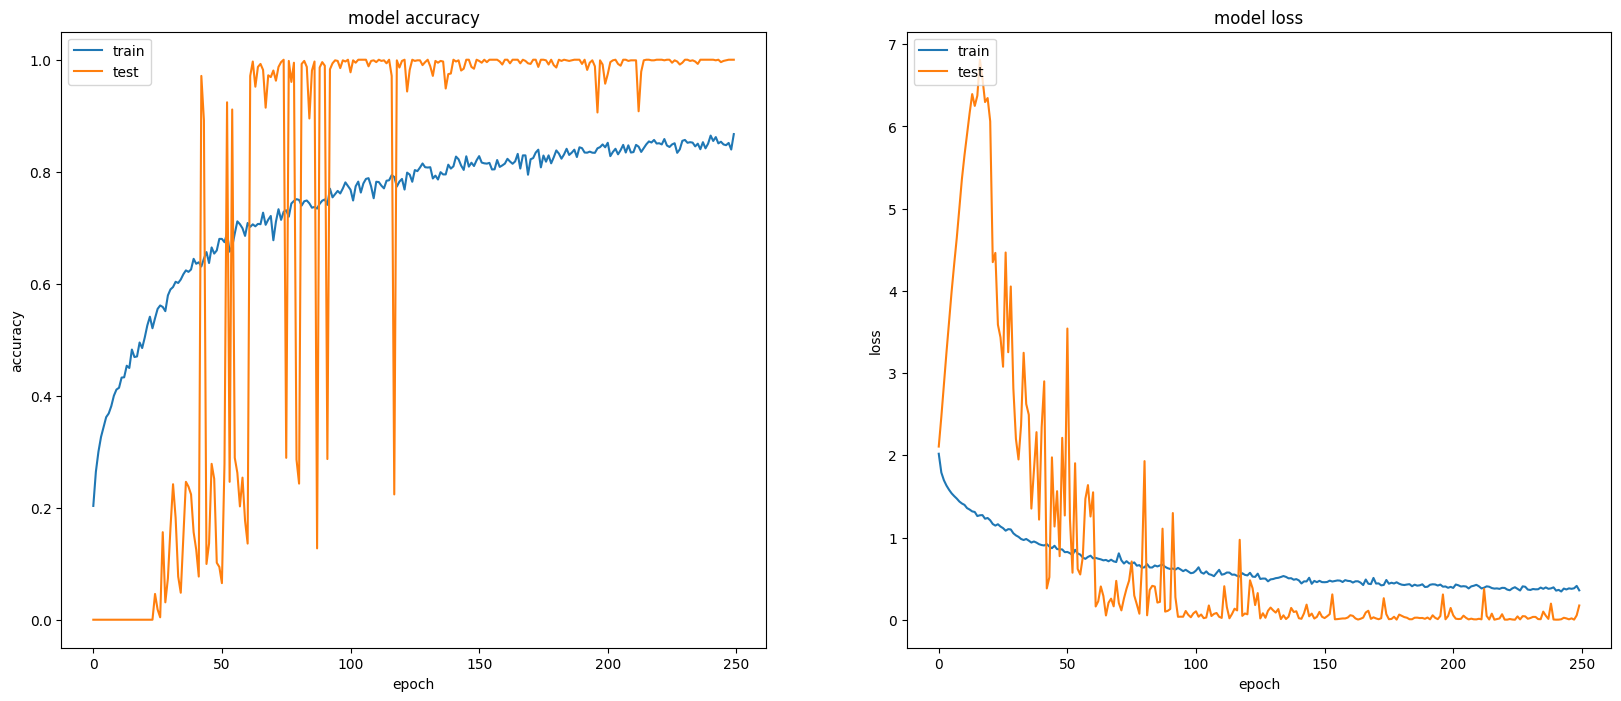

In [23]:
layers = [(100,"relu"),(100,"sigmoid",0.2),(20,"relu")]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 594us/step - loss: 0.6465 - accuracy: 0.7052


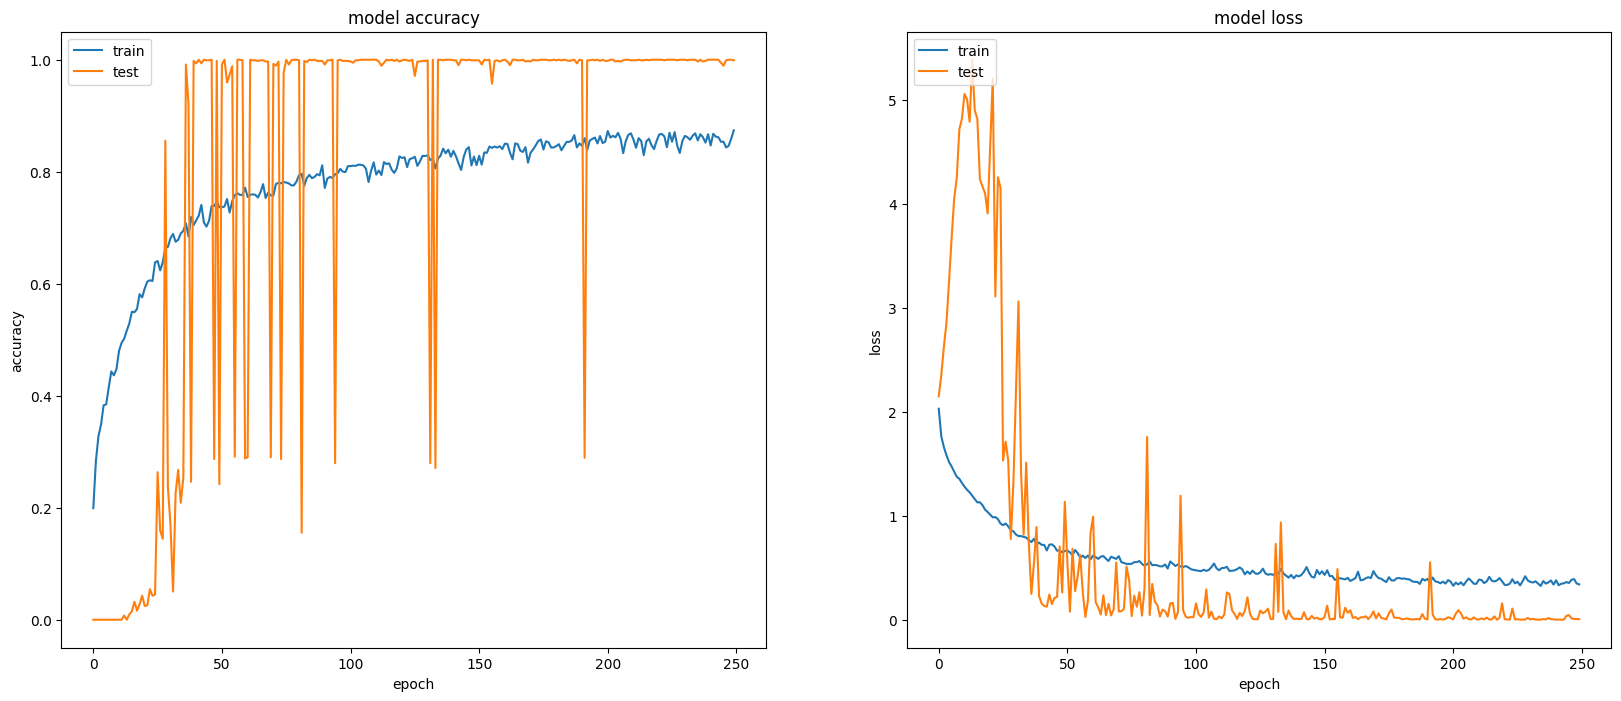

In [24]:
layers = [(100,"relu"),(100,"tanh",0.2),(20,"relu")]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 821us/step - loss: 0.9467 - accuracy: 0.6958


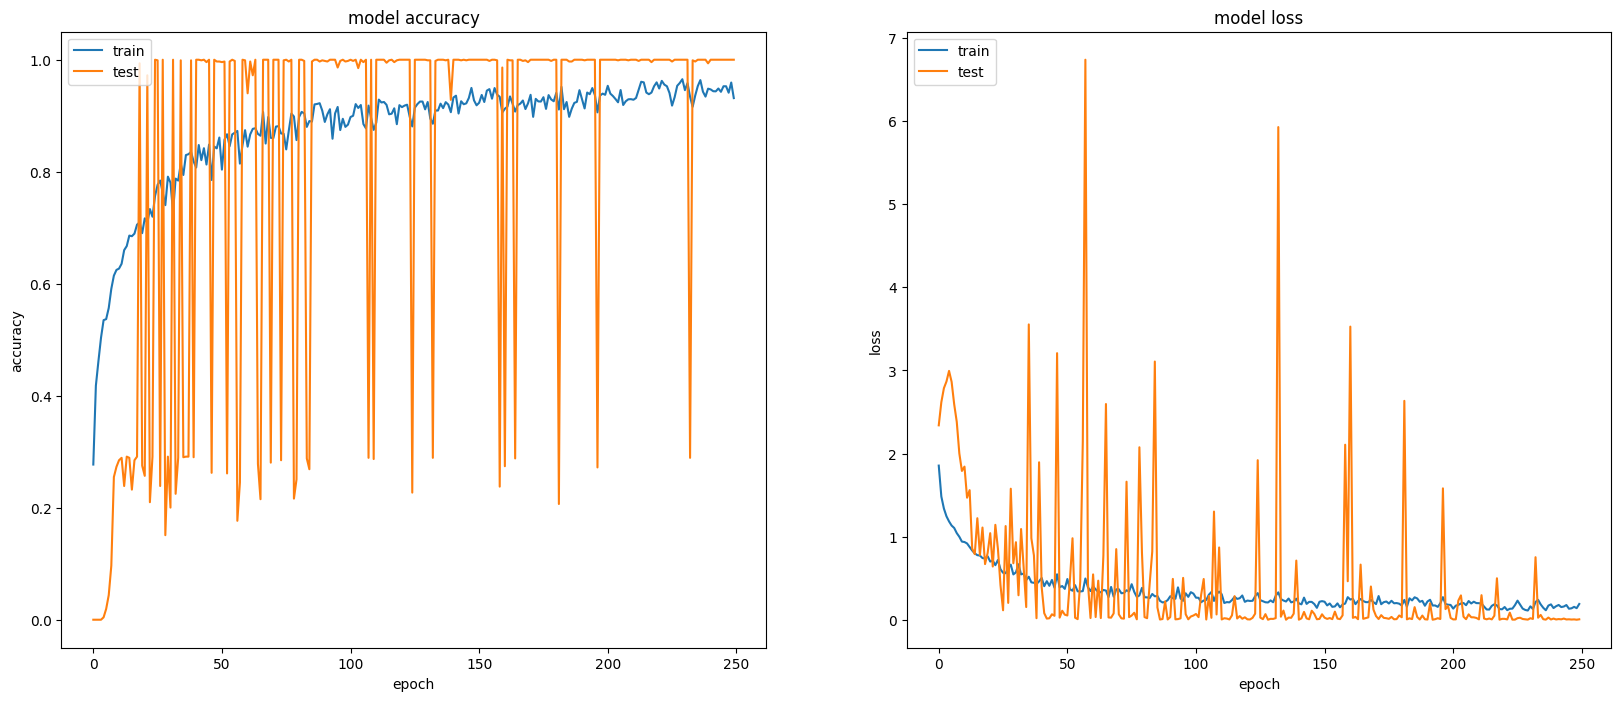

In [25]:
layers = [(300,"relu"), (210,"sigmoid"), (130,"relu"), (80,"relu")]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 858us/step - loss: 0.8622 - accuracy: 0.6572


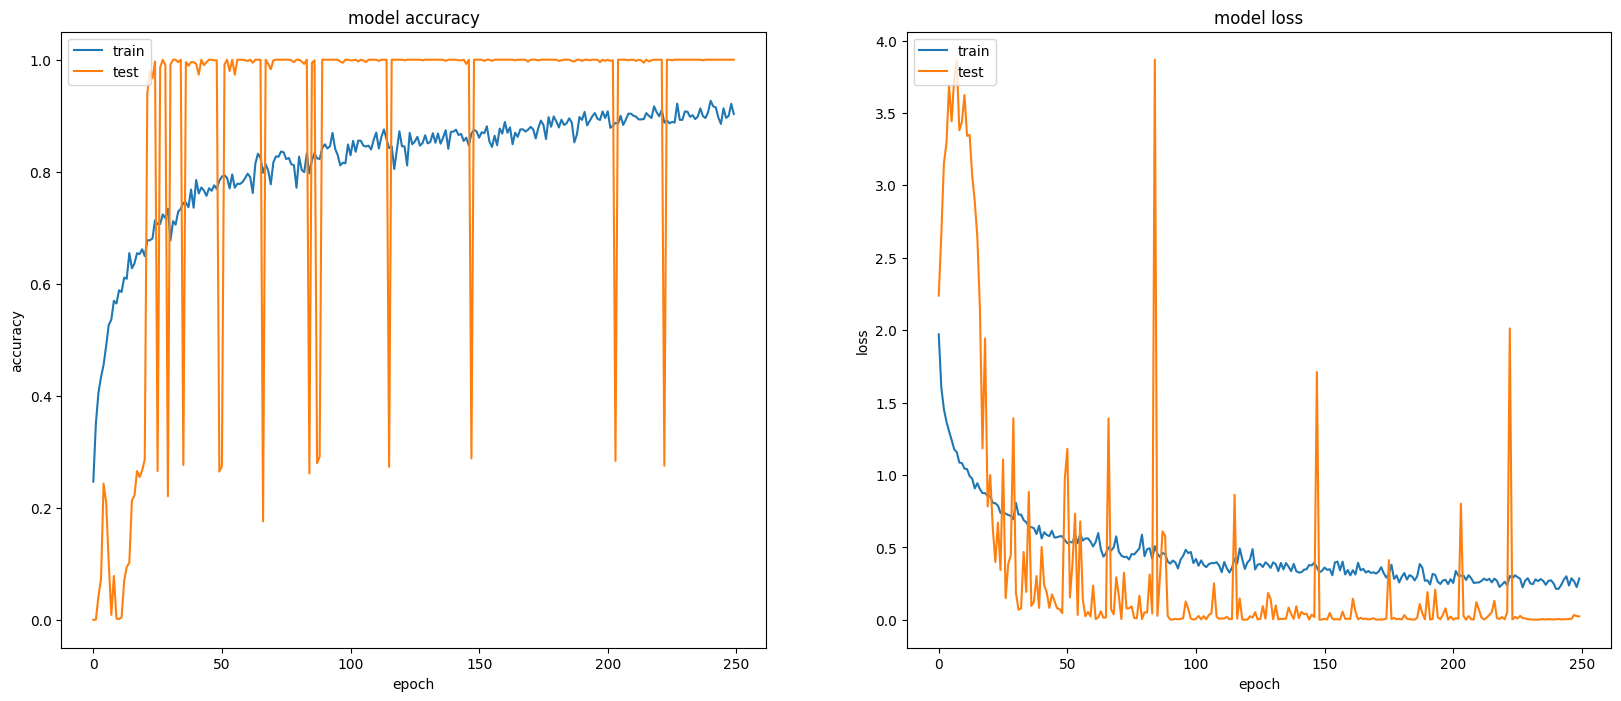

In [26]:
layers = [(300,"relu"), (210,"sigmoid",0.2), (130,"relu"), (80,"relu")]
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [27]:
models

[{'layers': [(50, 'relu')],
  'optimizer': 'adam',
  'batchSize': 128,
  'epochs': 250,
  'endActi': 'softmax',
  'best_lost': 1.5170859098434448,
  'best_accuracy': 0.2930591404438019,
  'loss': [1.9754523038864136,
   1.8182827234268188,
   1.7671923637390137,
   1.7408279180526733,
   1.7224469184875488,
   1.7076529264450073,
   1.6923668384552002,
   1.6781235933303833,
   1.667731761932373,
   1.6534240245819092,
   1.6410082578659058,
   1.624208688735962,
   1.6151361465454102,
   1.6058639287948608,
   1.5980778932571411,
   1.5911678075790405,
   1.5838168859481812,
   1.5746504068374634,
   1.5632010698318481,
   1.559250831604004,
   1.5503461360931396,
   1.5438144207000732,
   1.5354070663452148,
   1.5339583158493042,
   1.5247619152069092,
   1.5246094465255737,
   1.5181697607040405,
   1.5086570978164673,
   1.5064375400543213,
   1.5027618408203125,
   1.4999816417694092,
   1.4961775541305542,
   1.4919546842575073,
   1.4904578924179077,
   1.48062264919281,
   1.4

In [28]:
def get_best_acc_model(models):
    bestItem = max(models, key=lambda x:x['best_accuracy'])
    return bestItem
def get_best_loss_model(models):
    bestItem = min(models, key=lambda x:x['best_loss'])
    return bestItem

## Get the best Model by accuracy

In [29]:
best_model = get_best_acc_model(models)
best_model

{'layers': [(100, 'relu'), (100, 'tanh', 0.2), (20, 'relu')],
 'optimizer': 'adam',
 'batchSize': 128,
 'epochs': 250,
 'endActi': 'softmax',
 'best_lost': 0.646514356136322,
 'best_accuracy': 0.7052270770072937,
 'loss': [2.030910015106201,
  1.7625812292099,
  1.6615781784057617,
  1.5835338830947876,
  1.5184550285339355,
  1.4753203392028809,
  1.4264764785766602,
  1.3762105703353882,
  1.356808066368103,
  1.3172943592071533,
  1.2819169759750366,
  1.2510228157043457,
  1.2267420291900635,
  1.1948976516723633,
  1.1630836725234985,
  1.130238652229309,
  1.1308521032333374,
  1.1033132076263428,
  1.0606589317321777,
  1.0379241704940796,
  1.0121889114379883,
  0.9861021041870117,
  0.9888400435447693,
  0.9692871570587158,
  0.9264188408851624,
  0.9107872247695923,
  0.9265098571777344,
  0.8995069861412048,
  0.8619928956031799,
  0.8519799113273621,
  0.8209146857261658,
  0.8059863448143005,
  0.8056971430778503,
  0.7984881401062012,
  0.7909346222877502,
  0.76801627874

### Create the best model again and find now the best optimizer for this model
We create everytime the model new for the performance. Otherwise we must save every model and this don´t like our computer.

In [30]:
models = []

37/37 [==============================] - 0s 601us/step - loss: 0.9305 - accuracy: 0.5861


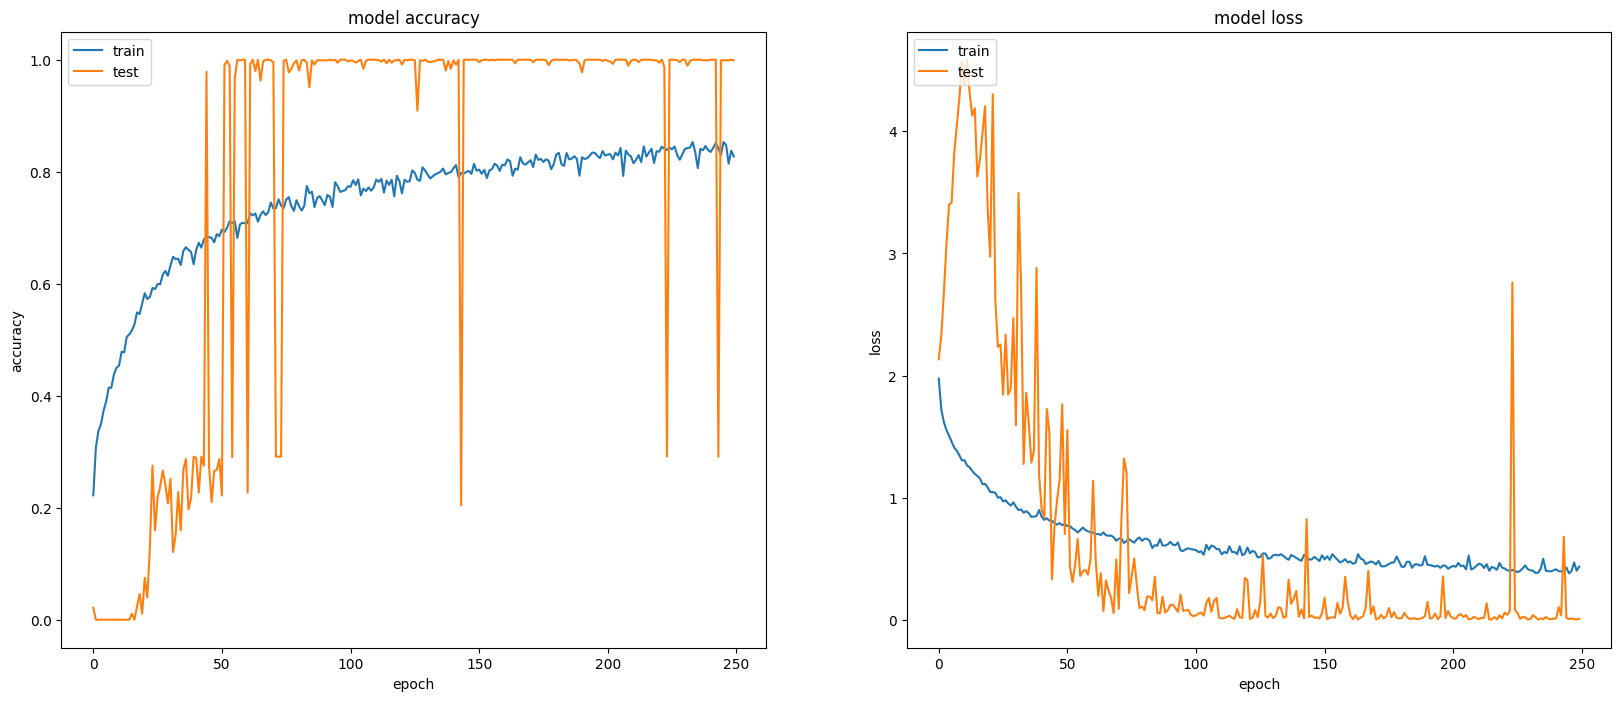

In [31]:
#Model with adam optimizer
layers = best_model['layers']
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 594us/step - loss: 1.1792 - accuracy: 0.5630


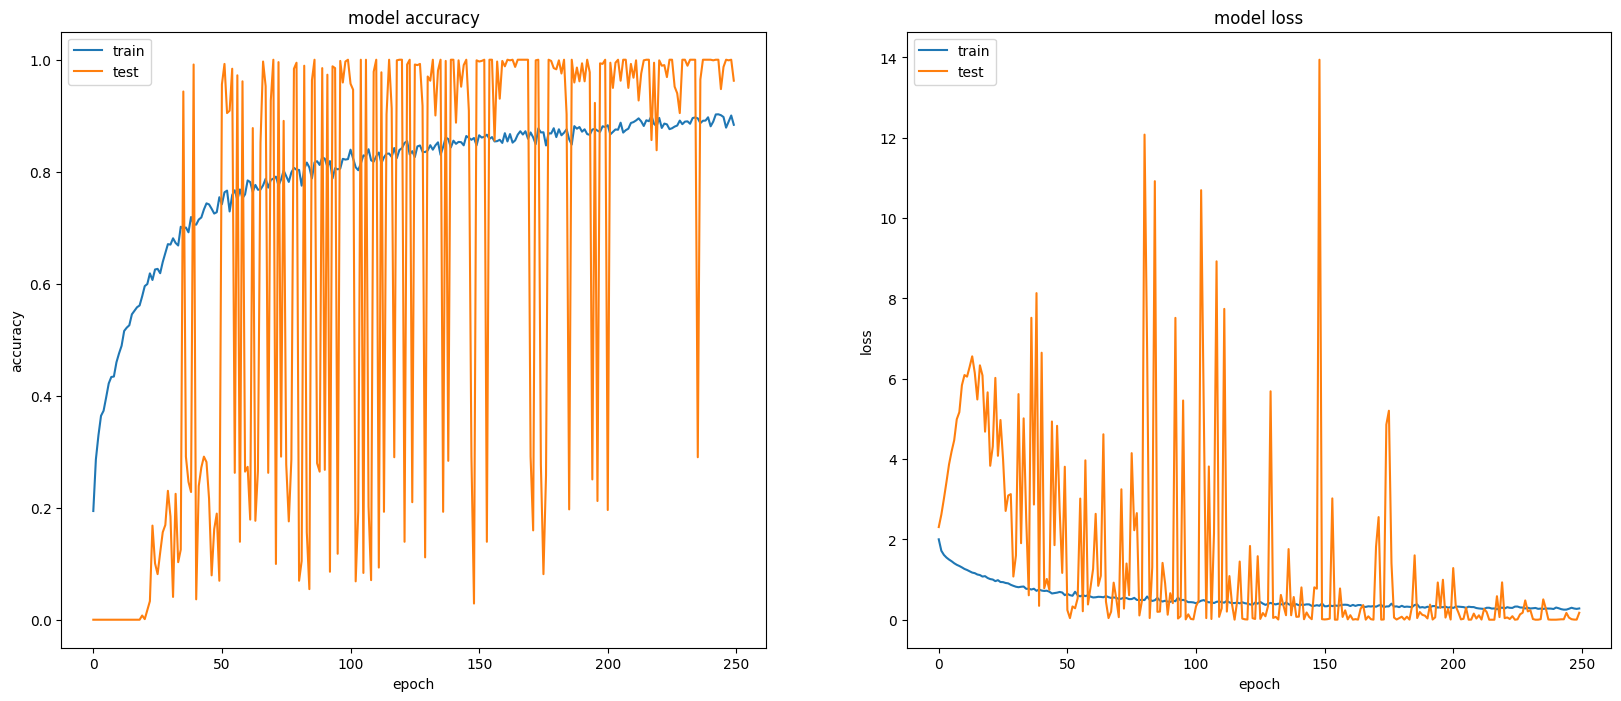

In [32]:
#Model with Nadam optimizer
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer='nadam', endActi=best_model['endActi'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 590us/step - loss: 1.6270 - accuracy: 0.2828


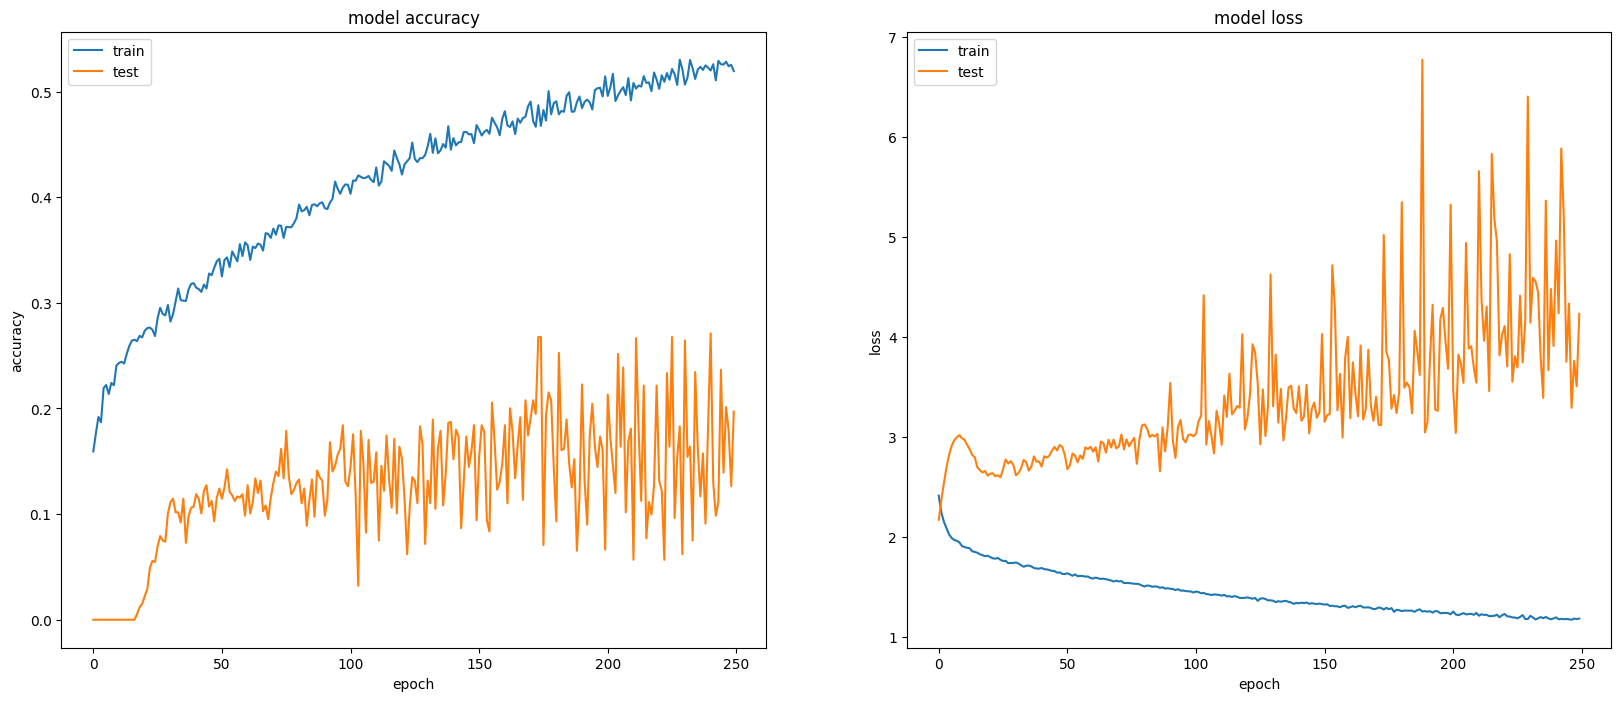

In [33]:
#Model with SGD optimizer
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer='sgd', endActi=best_model['endActi'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 607us/step - loss: 1.5021 - accuracy: 0.3033


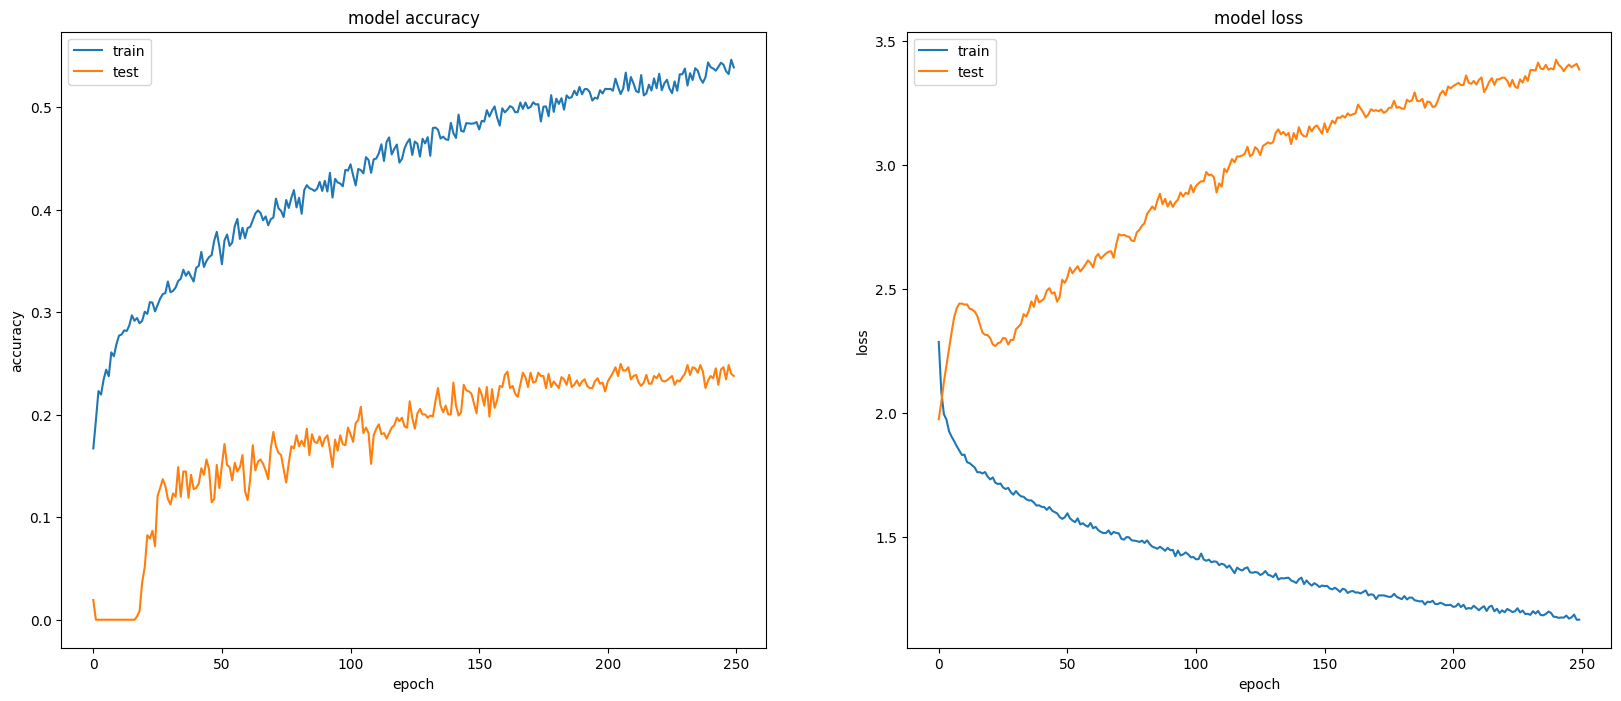

In [34]:
#Model with Adagrad optimizer
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer='adagrad', endActi=best_model['endActi'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

In [35]:
best_model = get_best_acc_model(models)
best_model

{'layers': [(100, 'relu'), (100, 'tanh', 0.2), (20, 'relu')],
 'optimizer': 'adam',
 'batchSize': 128,
 'epochs': 250,
 'endActi': 'softmax',
 'best_lost': 0.9304983615875244,
 'best_accuracy': 0.5861182808876038,
 'loss': [1.975234866142273,
  1.7198275327682495,
  1.6175097227096558,
  1.5534861087799072,
  1.5080369710922241,
  1.4599578380584717,
  1.41037118434906,
  1.3844537734985352,
  1.347121238708496,
  1.3060860633850098,
  1.3067041635513306,
  1.263614296913147,
  1.2491340637207031,
  1.2196913957595825,
  1.1957306861877441,
  1.177581787109375,
  1.1594408750534058,
  1.111384391784668,
  1.1129322052001953,
  1.0856820344924927,
  1.046343207359314,
  1.0469783544540405,
  1.0386290550231934,
  1.0007606744766235,
  1.0039681196212769,
  0.97015780210495,
  0.9787779450416565,
  0.9531447291374207,
  0.9357367753982544,
  0.9626056551933289,
  0.9270634651184082,
  0.8988010883331299,
  0.9037107229232788,
  0.8776684403419495,
  0.8901552557945251,
  0.87369734048843

In [36]:
layers = best_model['layers']
model, history = create_fit_model(input_data=X_bal, output_data=y_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)

37/37 [==============================] - 0s 592us/step - loss: 0.8035 - accuracy: 0.6932


## Save the best model

In [37]:
model.save('best_model')
model = 0

INFO:tensorflow:Assets written to: best_model/assets


## Load the best model

In [38]:
model = keras.models.load_model('best_model')

## Analyse the model

In [39]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def analyse_my_mode(model, history):
    model.summary()
    print("\n")
    predictions = model.predict(X_test, verbose=0)
    y_pred = (predictions > 0.5)
    y_test_=y_test.astype(int).tolist()
    print(confusion_matrix(y_test_, y_pred.argmax(axis=1)))
    print("\n")
    print(classification_report(y_true=y_test_,y_pred=y_pred.argmax(axis=1), target_names=y_labels,zero_division=0))
    print("\n")
    
    plot_acc_loss(history);

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 100)               600       
                                                                 
 batch_normalization_39 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_55 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_40 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_56 (Dense)            (None, 20)              

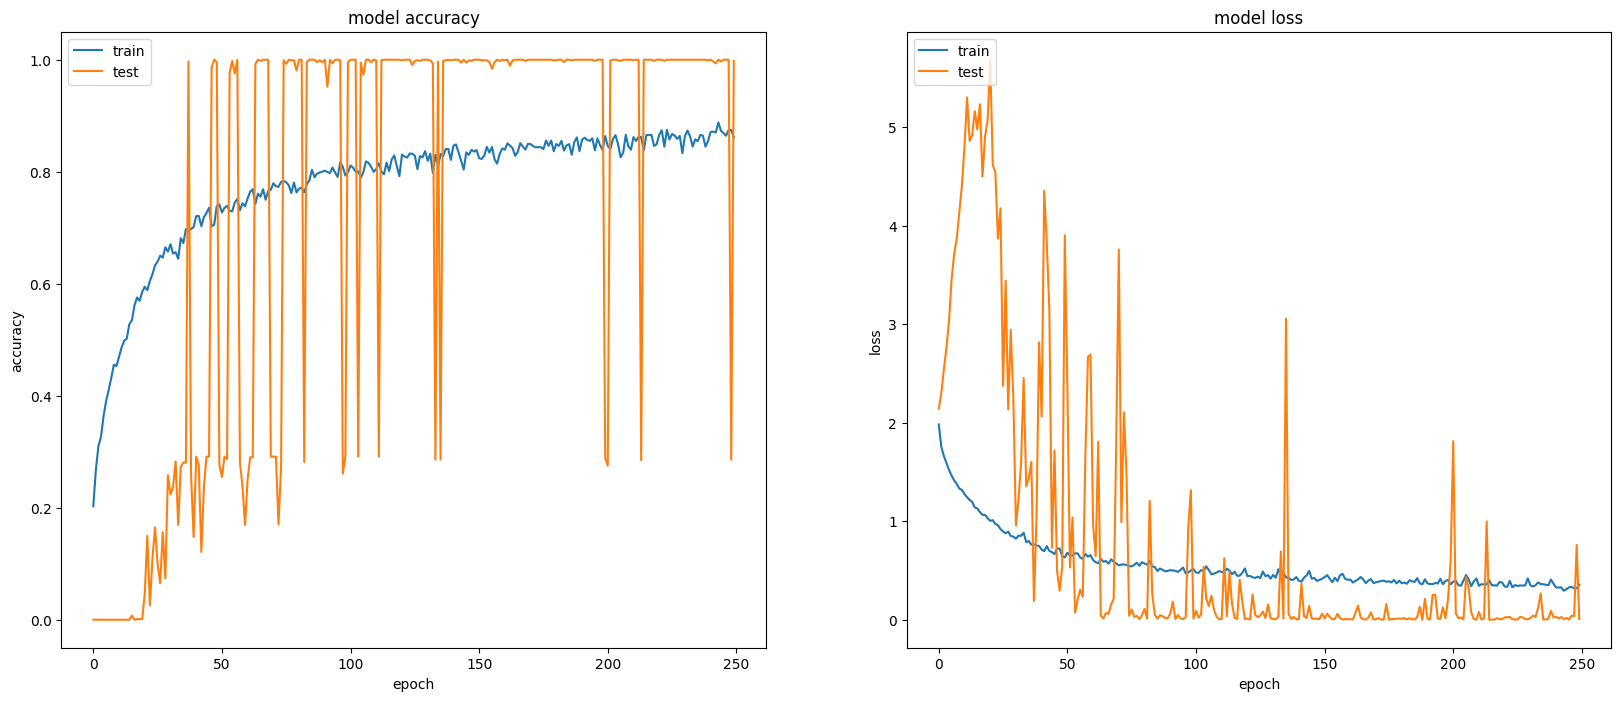

In [40]:
analyse_my_mode(model, history)

The following graph shows the different loss curves. We see we are close but there is still room for improvement. 

<img src="https://cs231n.github.io/assets/nn3/learningrates.jpeg">
(Effect of Learning rate on Loss (Source: CS231n Convolutional Neural Networks for Visual Recognition))

##  Model test

Finally, we test our model a little bit. For this we create a function that randomly creates five different cube values. We also plot the first predictions of the test data to visualize the accuracy.

In [41]:
def predict_result(diceOne, diceTwo, diceThree, diceFour, diceFive, printResult=False):
    _ = model.predict([[diceOne, diceTwo, diceThree, diceFour, diceFive]], verbose=0)
    
    if printResult:
        return _
    
    result = y_labels[np.argmax(_, axis=1)[0]]

    print(result)

In [42]:
diceOne = np.random.randint(low=1, high=6)
diceTwo = np.random.randint(low=1, high=6)
diceThree = np.random.randint(low=1, high=6)
diceFour = np.random.randint(low=1, high=6)
diceFive = np.random.randint(low=1, high=6)

print(diceOne,diceTwo,diceThree,diceFour,diceFive)
predict_result(diceOne,diceTwo,diceThree,diceFour,diceFive)

1 3 1 2 2
four-of-a-kind


In [43]:
def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(7), fontsize=10)
  plt.xticks(rotation=90)
  plt.yticks([])
  thisplot = plt.bar(y_labels, predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

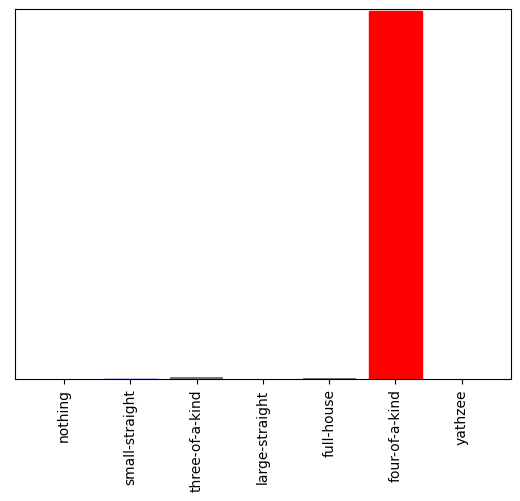

In [44]:
i = 0
prediction = model.predict([[1, 3, 2, 4, 3]], verbose=0)
plot_value_array(i, prediction[i], [1]) #small-straight

In [45]:
#Basic from: https://www.tensorflow.org/tutorials/keras/classification
def plot_bars(num_rows=5, num_cols=3):
    predictions = model.predict(X_test)
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 3*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, num_cols, i+1)
      plot_value_array(i, predictions[i], y_test.reset_index(drop=True))
      if type(X_bal) is not np.ndarray:
          dices = np.array(X_test.reset_index(drop=True))[i]
      else:
          dices = np.array(X_test)[i].astype(int)
      title = str(dices[0]) + "," + str(dices[1]) + "," + str(dices[2]) + "," + str(dices[3]) + "," + str(dices[4])
      plt.title(title)
      plt.subplots_adjust(hspace=1.2)
    plt.show()

37/37 [==============================] - 0s 602us/step


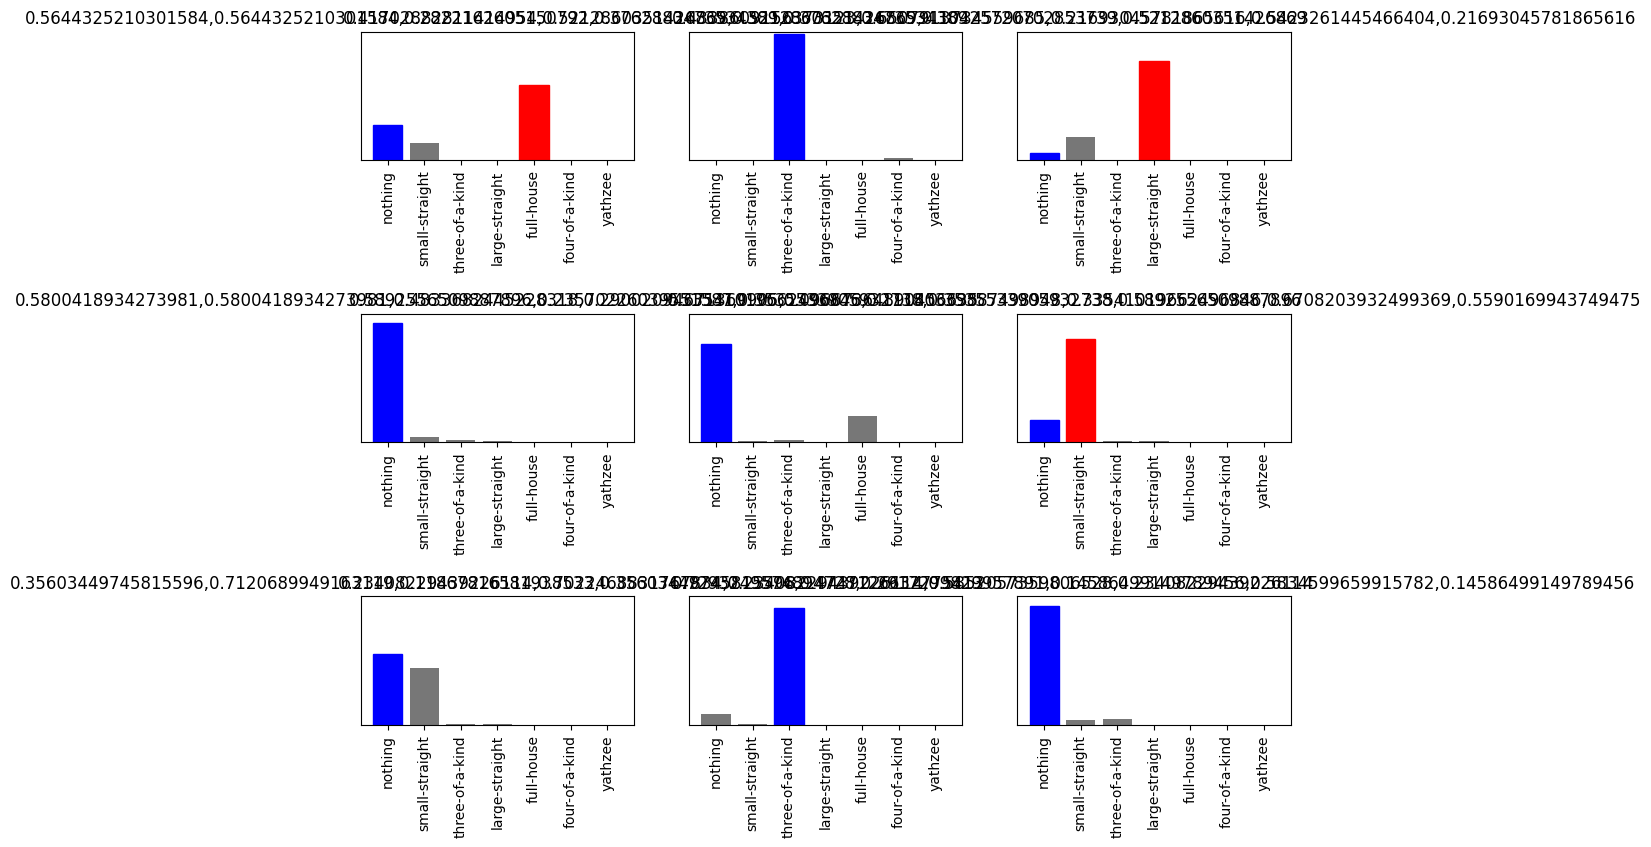

In [46]:
plot_bars(3,3)

## Conclusion